In [ ]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


1 bit LLM - https://arxiv.org/abs/2402.17764



## Installing necessary packages (this is google colab environment)

In [1]:
!pip install -q accelerate peft bitsandbytes transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00


In [ ]:
%pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 #transformers==4.48.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.15.1 requires accelerate>=0.34.0, but you have accelerate 0.21.0 which is incompatible.


In [ ]:
!pip install transformers==4.36.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00


In [3]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
%pip install --upgrade trl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade bitsandbytes

## Importing Necessary Libraries

In [4]:
import os
import numpy
import pandas
import torch
from datasets import load_dataset
from transformers import(
    AutoModelForCausalLM, #pretrained causal language model
    AutoTokenizer,     #
    BitsAndBytesConfig, #for configuring quantization
    HfArgumentParser, #cmd arguments
    TrainingArguments,
    pipeline,
    logging,
    GenerationConfig,
)
from peft import LoraConfig, PeftModel # Parameter efficient fine tuning and Low rank Adpation
from trl.trainer.sft_trainer import SFTTrainer #Supevised Fine tuning-SFT



# We need data for fine tuning LLama2
LLama2 requires data to be of a specific prompt template(for chat models) :
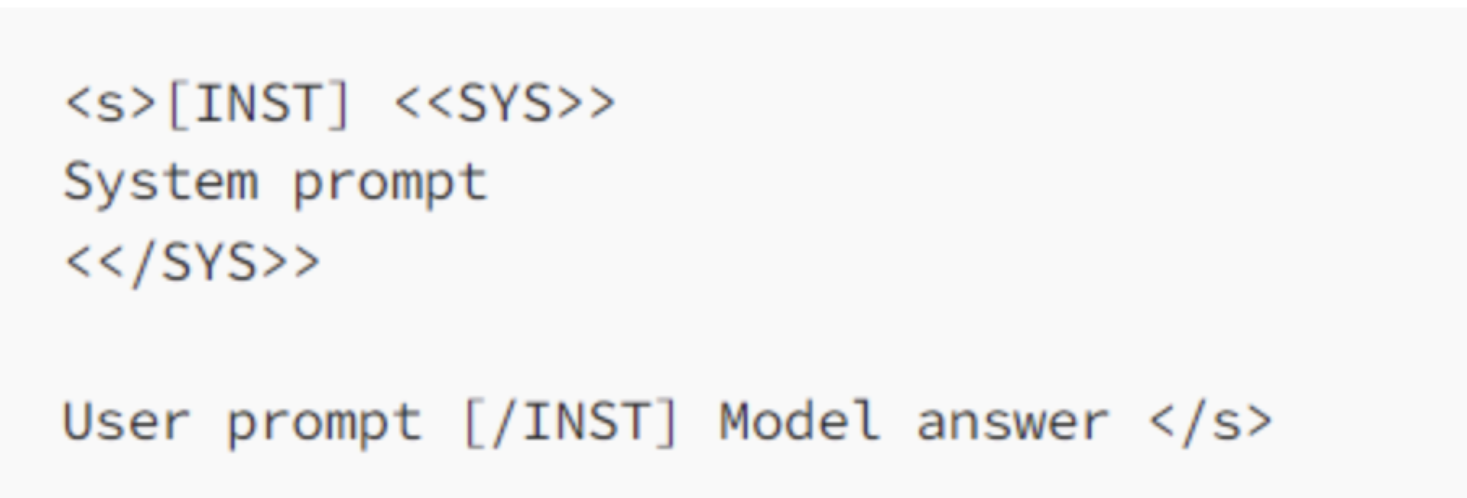

In [5]:
from datasets import load_dataset

data = load_dataset("Abirate/english_quotes")
data = data.map(lambda samples: tokenizer(samples["quote"]), batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

quotes.jsonl:   0%|          | 0.00/647k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip uninstall bitsandbytes

Found existing installation: bitsandbytes 0.45.2
Uninstalling bitsandbytes-0.45.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/bitsandbytes-0.45.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/bitsandbytes/*
Proceed (Y/n)? y
  Successfully uninstalled bitsandbytes-0.45.2


In [7]:
!pip install -q -U bitsandbytes

In [ ]:
!pip install git+https://github.com/TimDettmers/bitsandbytes.git

  Cloning https://github.com/TimDettmers/bitsandbytes.git to /tmp/pip-req-build-1b7284t_
  Running command git clone --filter=blob:none --quiet https://github.com/TimDettmers/bitsandbytes.git /tmp/pip-req-build-1b7284t_
  Resolved https://github.com/TimDettmers/bitsandbytes.git to commit 8ed7d97b4901b4f01f9ac04262e3a34d1cb6941a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bitsandbytes: filename=bitsandbytes-0.45.3.dev0-cp311-cp311-linux_x86_64.whl size=90542 sha256=0d0ff80453c91ab94bf8a4990b8a14fb49891bb9de8def1ea78fcaef60d63407
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xykhabs/wheels/85/06/31/de7992855a6f6df8812a233c904db938c7a990eb338eadb41a
Successfully built bitsandbytes


In [11]:
model_one = "meta-llama/Llama-2-7b-chat-hf" #accessed via meta on Huggingface : model_id = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(model_one)
model = AutoModelForCausalLM.from_pretrained(model_one, quantization_config=bnb_config, device_map={"":0})

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:

!pip install -U bitsandbytes

  Using cached bitsandbytes-0.45.2-py3-none-manylinux_2_24_x86_64.whl.metadata (5.8 kB)
Using cached bitsandbytes-0.45.2-py3-none-manylinux_2_24_x86_64.whl (69.7 MB)


# Lets do some traning setup

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    # target_modules=["query_key_value"],
    target_modules=["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj"], #specific to Llama models.
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Data Setup